# 0 - IMPORT LIBRARIES

In [1]:
import keras_cv as kcv
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Sequential

import os
import math
import random
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Random seed for reproducibility
seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# 1 - LOAD & AUGMENT DATA

In [3]:
X =  np.load('/kaggle/input/dataset-bal/X.npy')
y =  np.load('/kaggle/input/dataset-bal/y.npy')

print(X.shape)
print(y.shape)

(18640, 96, 96, 3)
(18640, 1)


In [4]:
#2 - SPLIT DATA
split_par = 0.2

X_train, X_test_val, y_train, y_test_val = train_test_split(X, 
                                                            y,
                                                            random_state=seed,
                                                            test_size = split_par,
                                                            stratify=np.argmax(y,axis=1))

X_test, X_val, y_test, y_val = train_test_split(X_test_val, 
                                                y_test_val, 
                                                random_state=seed, 
                                                test_size = 0.5, 
                                                stratify=np.argmax(y_test_val,axis=1))

y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
y_val = tfk.utils.to_categorical(y_val)

In [5]:
#Apply augmentation
randaug=kcv.layers.RandAugment(value_range=(0,255),seed=seed)
X_train = randaug(X_train)

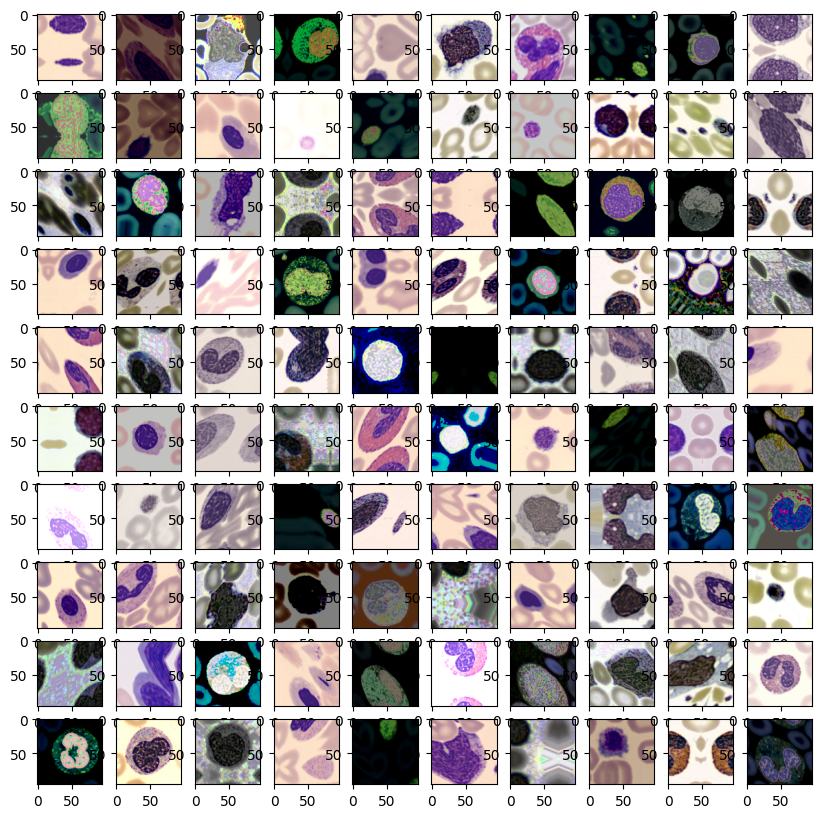

In [6]:
#Plot first num images to see the augmentations applied
num = 100

fig = plt.figure(figsize=(10,10))
for i in range(1, num+1):
    fig.add_subplot(10, 10, i)
    plt.imshow(X_train[i]/255)
plt.show()

# 2 - BUILD MODEL

In [14]:
# Initialise EfficientNetB3 model with imagent problem weights

effnetB3 = tfk.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(96, 96, 3),
    pooling='avg',
    classes=8,
    classifier_activation=None,
)

effnetB3.trainable = False

#Define given inputs
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

#Create sequantial layers to apply little geometric augmentations to the inputs
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal", seed = seed),
    tfkl.RandomTranslation(0.2, 0.2)
], name='preprocessing')

x = augmentation(inputs)
x = effnetB3(x)

#Squeeze-and-Excitation Attention (similar to SE block)
se = tfkl.Dense(x.shape[-1] // 4, activation='relu')(x)  # Squeeze step
se = tfkl.Dense(x.shape[-1], activation='sigmoid')(se)  # Excitation step
x = tfkl.Multiply()([x, se])  # Scale feature maps by learned importance weights

# Add Dense, Dropout and Batch Normalization layers
x = tfkl.Dense(128, activation='relu', name='dense_1')(x)
x = tfkl.BatchNormalization(name='batch_norm_1')(x)
x = tfkl.Dropout(0.4, name='dropout_1')(x)

x = tfkl.Dropout(0.2, name='dropout_2')(x)

#Define last layer
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense2')(x)

#Create complete model and compile it
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-4), metrics=['accuracy','F1Score'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=False)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing       │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 1536)      │ 10,783,535 │ preprocessing[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 384)       │    590,208 │ efficientnetb3[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1536)      │    591,360 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1536)      │          0 │ efficientnetb3[0… │
│ (Multiply)          │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    196,736 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 8)         │      1,032 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,163,383 (46.40 MB)

 Trainable params: 1,379,592 (5.26 MB)

 Non-trainable params: 10,783,791 (41.14 MB)

# 3 - TRANSFER LEARNING

In [15]:
# Train the model
tl_history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=40,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file
model_filename = 'Model_pre.keras'
tl_model.save(model_filename)

del tl_model

Epoch 1/40


2024-11-24 20:17:31.504914: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/model_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - F1Score: 0.2620 - accuracy: 0.2635 - loss: 2.4324 - val_F1Score: 0.6807 - val_accuracy: 0.6888 - val_loss: 1.1878
Epoch 2/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - F1Score: 0.4377 - accuracy: 0.4408 - loss: 1.6237 - val_F1Score: 0.7543 - val_accuracy: 0.7554 - val_loss: 0.7749
Epoch 3/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - F1Score: 0.4831 - accuracy: 0.4852 - loss: 1.4521 - val_F1Score: 0.7607 - val_accuracy: 0.7629 - val_loss: 0.7022
Epoch 4/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - F1Score: 0.5229 - accuracy: 0.5251 - loss: 1.3324 - val_F1Score: 0.7838 - val_accuracy: 0.7838 - val_loss: 0.6520
Epoch 5/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - F1Score: 0.5481 - accuracy: 0.5502 - loss: 1.2647 - val_F1Score: 0.7931 - val_accuracy: 0.7935 - val_loss: 0.6216
Epoch 6/40
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - F1Score: 0.5625 - accuracy: 0.5641 - loss: 1.2210 - val_F1Score: 0.7959 - val_accuracy: 0.7956 - val_loss

# 4 - FINE TUNING

In [16]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Model_pre.keras')

In [18]:
# Set the EfficientNetB3 model layers as trainable
ft_model.get_layer('efficientnetb3').trainable = True

# Set all EfficientNet layers as non-trainable
for layer in ft_model.get_layer('efficientnetb3').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetb3').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        
# Set the number of layers to freeze
N = 100

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetb3').layers[:N]):
    layer.trainable = False

# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(learning_rate=5e-5, weight_decay=1e-5), metrics=['accuracy','F1Score'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file
model_filename = 'Model_post.keras'
ft_model.save(model_filename)

Epoch 1/100


2024-11-24 20:29:47.450016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/model_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 ━━━━━━━━━━━━━━━━━━━━ 52s 132ms/step - F1Score: 0.7152 - accuracy: 0.7160 - loss: 0.8159 - val_F1Score: 0.9498 - val_accuracy: 0.9506 - val_loss: 0.1620
Epoch 2/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - F1Score: 0.8763 - accuracy: 0.8766 - loss: 0.3803 - val_F1Score: 0.9668 - val_accuracy: 0.9673 - val_loss: 0.1020
Epoch 3/100
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - F1Score: 0.9084 - accuracy: 0.9083 - loss: 0.2740

# 5 - HISTORY PLOT

In [ ]:
# Plot loss
fig = plt.figure()
plt.plot(ft_history['loss'], color='teal', label='loss')
plt.plot(ft_history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Plot the training
plt.figure(figsize=(15,5))
plt.plot(ft_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

#Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# 6 - EVAULATION ON TEST SET

In [ ]:
pred = np.argmax(ft_model.predict(X_test), axis=1)

In [ ]:
true = np.argmax(y_test,axis=1)
cm = confusion_matrix(true, pred)
labels_cm = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Calculate accuracy
accuracy = accuracy_score(true, pred)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")
# Calculate precision
precision = precision_score(true, pred, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Normalized confusion matrix by class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# 7 - ZIP MODEL

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('Model_post.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
filename = f'efficientnet-b3_randaug'
!zip {filename} model.py Model_post.keras